# PLANET: Understanding the Amazon from Space

**IMPORT LIBRARIES**

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
import pathlib

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import cv2

from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import SGD

from sklearn.utils import shuffle
from sklearn.metrics import fbeta_score

**DOWNLOAD DATASETS**

In [2]:
# set path
path = '../input/planets-dataset/'
os.chdir(path)   

for dirname, _, filenames in os.walk('planet'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [3]:
!ls

planet	test-jpg-additional


In [4]:
# load train and test datasets
train_data = pd.read_csv("planet/planet/train_classes.csv")
test_data = pd.read_csv("planet/planet/sample_submission.csv")

# preview train dataset
train_data.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


**INSPECT IMAGE LABELS**

In [5]:
# Build list with unique labels
label_list = []
for tag_str in train_data.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

            
# Display label list and length 
print(f'There are {len(train_data)} data samples, with {len(label_list)} possible classes.', '\n' 
      f'The Label list includes {label_list}')

There are 40479 data samples, with 17 possible classes. 
The Label list includes ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


In [6]:
# Split the tags column to get the unique labels
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in train_data['tags'].values])))


# Create label map
label_map = {l: i for i, l in enumerate(labels)}

print(f'label_map = {label_map},\n length = {len(label_map)}')

label_map = {'primary': 0, 'cultivation': 1, 'clear': 2, 'road': 3, 'cloudy': 4, 'selective_logging': 5, 'blow_down': 6, 'habitation': 7, 'partly_cloudy': 8, 'water': 9, 'haze': 10, 'agriculture': 11, 'conventional_mine': 12, 'blooming': 13, 'slash_burn': 14, 'artisinal_mine': 15, 'bare_ground': 16},
 length = 17


In [7]:
# Add onehot features for every label
train_tag_data = train_data.copy()
for label in label_list:
    train_tag_data[label] = train_tag_data['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)

# Display head
train_tag_data.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


There is 17 unique labels including {'primary', 'cultivation', 'clear', 'road', 'cloudy', 'selective_logging', 'blow_down', 'habitation', 'partly_cloudy', 'water', 'haze', 'agriculture', 'conventional_mine', 'blooming', 'slash_burn', 'artisinal_mine', 'bare_ground'}


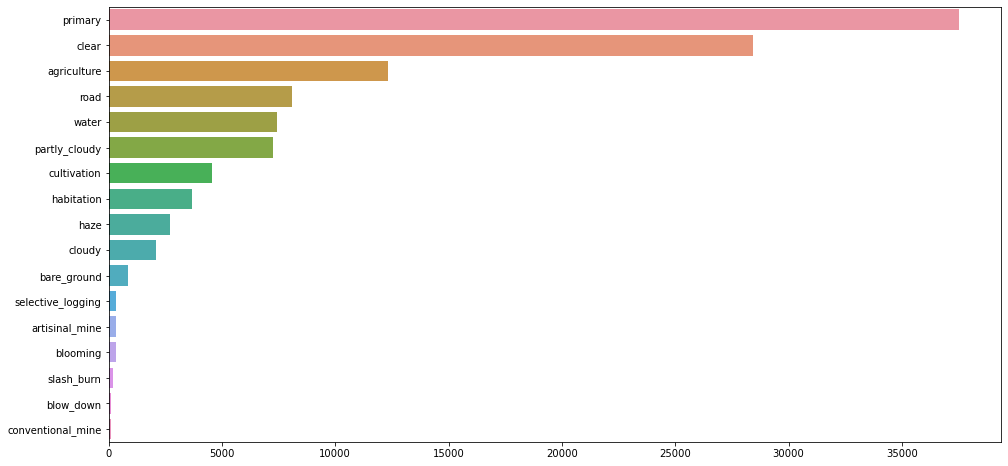

In [8]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in train_tag_data['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))


# Histogram of label instances
tag_labels = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=tag_labels, y=tag_labels.index, orient='h')

**INSPECT COOCCURENCE MATRICES**

,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
haze,2697,2670,672,0,613,129,394,202,3,0,0,2,41,5,4,5,0
primary,2670,37513,11972,27668,7001,3469,7728,4455,209,0,7175,94,683,324,332,340,98
agriculture,672,11972,12315,9150,2712,2737,6034,3377,119,0,2493,24,225,38,32,65,22
clear,0,27668,9150,28431,5502,3090,6295,3527,173,0,0,70,747,307,311,308,85
water,613,7001,2712,5502,7411,915,2125,868,24,0,1295,26,206,299,16,49,3
habitation,129,3469,2737,3090,915,3660,2786,895,41,0,441,36,163,29,4,13,3
road,394,7728,6034,6295,2125,2786,8071,1294,36,0,1382,59,323,110,10,151,2
cultivation,202,4455,3377,3527,868,895,1294,4477,126,0,748,4,89,18,35,58,8
slash_burn,3,209,119,173,24,41,36,126,209,0,33,0,10,0,2,2,2
cloudy,0,0,0,0,0,0,0,0,0,2089,0,0,0,0,0,0,0


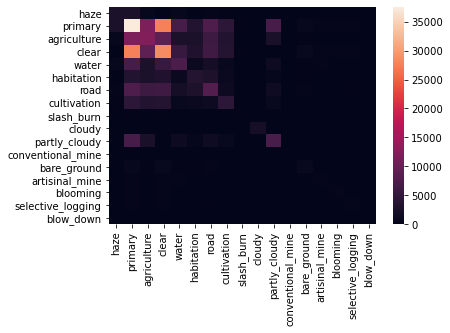

In [9]:
# function for cooocurence matrix plotting
def make_cooccurence_matrix(labels):
    numeric_data = train_tag_data[labels]; 
    c_matrix = numeric_data.T.dot(numeric_data)
    sns.heatmap(c_matrix)
    return c_matrix
    
# Compute the co-ocurrence matrix
make_cooccurence_matrix(label_list)

,clear,partly_cloudy,haze,cloudy
clear,28431,0,0,0
partly_cloudy,0,7261,0,0
haze,0,0,2697,0
cloudy,0,0,0,2089


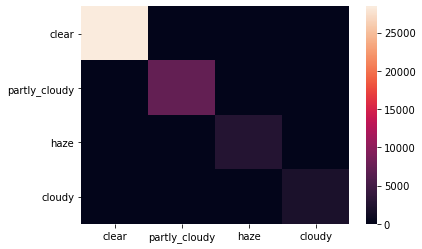

In [10]:
# plot weather element cooccurence matrix
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
make_cooccurence_matrix(weather_labels)

,primary,agriculture,water,cultivation,habitation
primary,37513,11972,7001,4455,3469
agriculture,11972,12315,2712,3377,2737
water,7001,2712,7411,868,915
cultivation,4455,3377,868,4477,895
habitation,3469,2737,915,895,3660


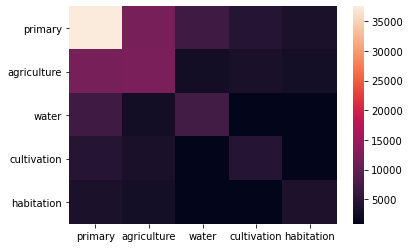

In [11]:
# plot land-use element classes cooccurence matrix
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation']
make_cooccurence_matrix(land_labels)

**PREVIEW IMAGES IN EACH CATEGORY**

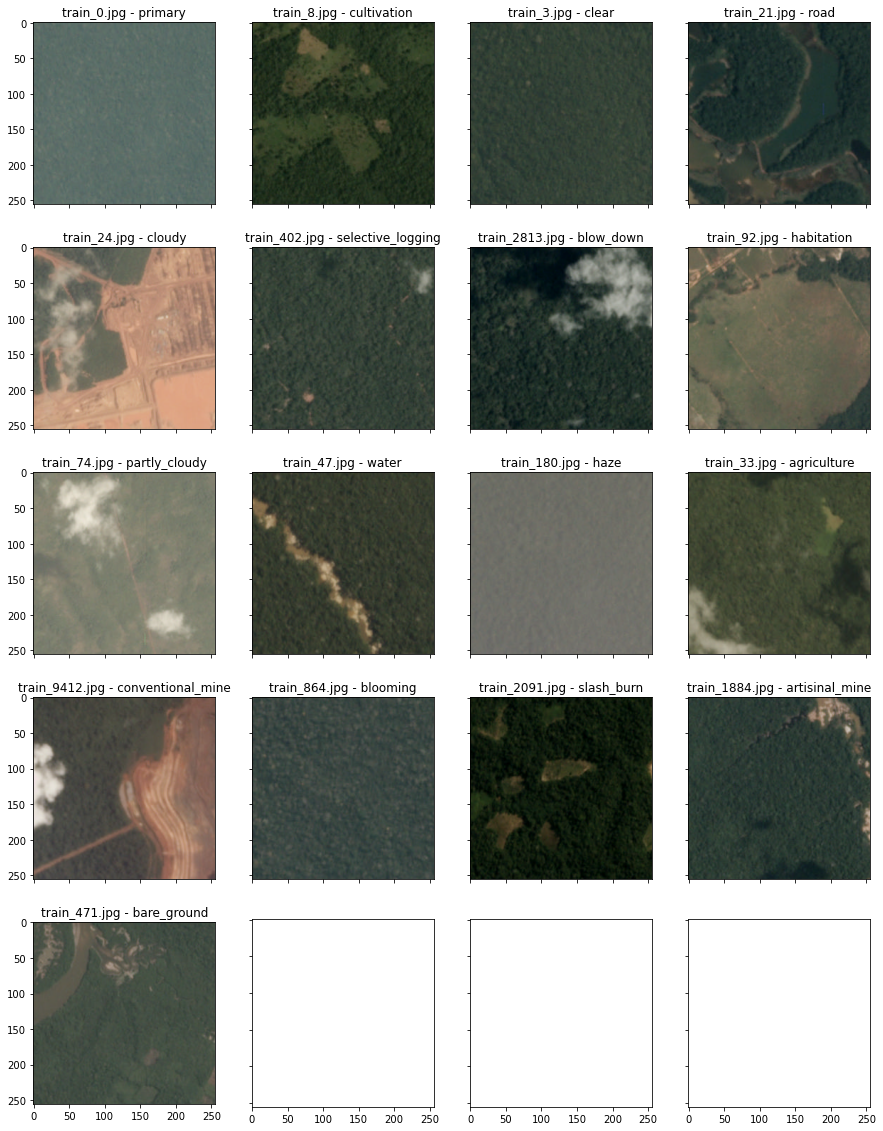

In [12]:
images = [train_data[train_data['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images, labels_set)):
    img = mpimg.imread('planet/planet/train-jpg' + '/' + image_name)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))

**DATA PRE-PROCESSING**

Data Length Check

In [13]:
# Determining if the length of the train and test dataset csv file equals the actual number of images in the folder

# Assign train and the two test dataset paths
# train path
train_img_dir = pathlib.Path('planet/planet/train-jpg')
train_img_path = sorted(list(train_img_dir.glob('*.jpg')))

# test path
test_img_dir = pathlib.Path('planet/planet/test-jpg')
test_img_path = sorted(list(test_img_dir.glob('*.jpg')))

# additional test path
test_add_img_dir = pathlib.Path('test-jpg-additional')
test_add_img_path = sorted(list(test_add_img_dir.glob('*/*.jpg')))

# Length Confirmation
assert len(train_img_path) == len(train_data)
print(len(test_img_path)+len(test_add_img_path))

61191


Image Preprocessing

In [14]:
# define input size
input_size = 64

In [15]:
# creating x_train and y_train
x_train = []
y_train = []

for f, tags in tqdm(train_data.values, miniters=1000):
    img = cv2.imread('planet/planet/train-jpg/{}.jpg'.format(f))
    img = cv2.resize(img, (input_size, input_size))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    x_train.append(img)
    y_train.append(targets)
        
x_train = np.array(x_train, np.float32)
y_train = np.array(y_train, np.uint8)

print(x_train.shape)
print(y_train.shape)

100%|██████████| 40479/40479 [01:40<00:00, 404.27it/s]


(40479, 64, 64, 3)
(40479, 17)


In [16]:
# creating x_test
x_test = []

test_jpg_dir = 'planet/planet/test-jpg'
test_image_names = os.listdir(test_jpg_dir)

n_test = len(test_image_names)
test_classes = test_data.iloc[:n_test, :]
add_classes = test_data.iloc[n_test:, :]

test_jpg_add_dir = 'test-jpg-additional/test-jpg-additional'
test_add_image_names = os.listdir(test_jpg_add_dir)

for img_name, _ in tqdm(test_classes.values, miniters=1000):
    img = cv2.imread(test_jpg_dir + '/{}.jpg'.format(img_name))
    x_test.append(cv2.resize(img, (64, 64)))
    
for img_name, _ in tqdm(add_classes.values, miniters=1000):
    img = cv2.imread(test_jpg_add_dir + '/{}.jpg'.format(img_name))
    x_test.append(cv2.resize(img, (64, 64)))

x_test = np.array(x_test, np.float32)
print(x_test.shape)

100%|██████████| 20522/20522 [01:07<00:00, 303.75it/s]


(61191, 64, 64, 3)


In [17]:
# split the train data into train and validation data sets
X_train = x_train[ :33000]
Y_train = y_train[ :33000]

X_valid = x_train[33000: ]
Y_valid = y_train[33000: ]

**MODEL TRAINING**

Define Model Architecture

In [18]:
# specify sizes (batch and model input) and number of input channels
input_size = 64
input_channels = 3
batch_size = 64

In [19]:
# Add model parameters including dropout, layers and activation function
base_model = VGG16(include_top=False,
                   weights='imagenet',
                   input_shape=(input_size, input_size, input_channels))

model = Sequential()
model.add(BatchNormalization(input_shape=(input_size, input_size, input_channels)))

model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(17, activation='sigmoid'))

58892288/58889256 [==============================] - 0s 0us/step


In [20]:

path = '/kaggle/working'
os.chdir(path)   

In [21]:

# define model training optimizer parameters
optimizer  = SGD(lr=0.01)
model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=0),
                ModelCheckpoint(filepath='weights/best_weights',
                                 save_best_only=True,
                                 save_weights_only=True)]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 64, 64, 3)         12        
_________________________________________________________________
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 17)                34833     
Total params: 14,749,533
Trainable params: 14,749,527
Non-trainable params: 6
_________________________________________________________________


In [22]:
# train model
history = model.fit(x=X_train, y=Y_train, validation_data=(X_valid, Y_valid),
                  batch_size=batch_size,verbose=2, epochs=15,callbacks=callbacks,shuffle=True)

Epoch 1/15
516/516 - 25s - loss: 0.1906 - accuracy: 0.7358 - val_loss: 0.1352 - val_accuracy: 0.8829
Epoch 2/15
516/516 - 24s - loss: 0.1410 - accuracy: 0.7118 - val_loss: 0.1220 - val_accuracy: 0.7337
Epoch 3/15
516/516 - 24s - loss: 0.1298 - accuracy: 0.6974 - val_loss: 0.1176 - val_accuracy: 0.8191
Epoch 4/15
516/516 - 24s - loss: 0.1226 - accuracy: 0.7030 - val_loss: 0.1135 - val_accuracy: 0.7990
Epoch 5/15
516/516 - 24s - loss: 0.1178 - accuracy: 0.6957 - val_loss: 0.1080 - val_accuracy: 0.7837
Epoch 6/15
516/516 - 24s - loss: 0.1143 - accuracy: 0.6899 - val_loss: 0.1096 - val_accuracy: 0.8144
Epoch 7/15
516/516 - 24s - loss: 0.1116 - accuracy: 0.7173 - val_loss: 0.1071 - val_accuracy: 0.8272
Epoch 8/15
516/516 - 24s - loss: 0.1090 - accuracy: 0.7124 - val_loss: 0.1035 - val_accuracy: 0.7607
Epoch 9/15
516/516 - 24s - loss: 0.1069 - accuracy: 0.7274 - val_loss: 0.1064 - val_accuracy: 0.7994
Epoch 10/15
516/516 - 24s - loss: 0.1054 - accuracy: 0.7234 - val_loss: 0.1018 - val_accura

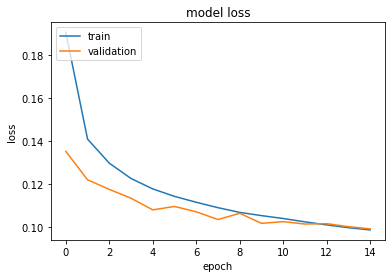

In [23]:
# summarize and plot train loss and valid loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**MODEL EVALUATION**

In [24]:
# Check validation accuracy
p_valid = model.predict(X_valid, batch_size = batch_size, verbose=1)
print(fbeta_score(Y_valid, np.array(p_valid) > 0.18, beta=2, average='samples'))

117/117 [==============================] - 2s 13ms/step
0.914618709687456


In [25]:
# Model Prediction on the test data
y_pred = []
p_test = model.predict(x_test, batch_size=batch_size, verbose=2)
y_pred.append(p_test)

957/957 - 13s


In [40]:
# Create a dataframe with the right predictions of the test dataset
result = np.array(y_pred[0])
for i in range(1, len(y_pred)):
    result += np.array(y_pred[i])
result = pd.DataFrame(result, columns=labels)

In [41]:
# Translating the probability predictions to the unique labels
preds = []
for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.loc[[i]]
    a = a.apply(lambda x: x>0.2, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))

100%|██████████| 61191/61191 [02:05<00:00, 486.05it/s]


In [42]:
# Replacing the tags columns with the predicted labels
test_data['tags'] = preds
test_data.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary clear
4,test_4,primary cloudy partly_cloudy


In [43]:
# Converting the dataframe to a csv file for submission
test_data.to_csv('amazon_sample_submission10.csv', index=False)